<a href="https://colab.research.google.com/github/Adiaslow/PepLab/blob/main/peplab/analysis/prediction/permeability/CycPepGAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install Packages
_ = !pip install rdkit-pypi
_ = !pip install -q pydot
_ = !pip install torch
_ = !pip install torch-geometric

In [ ]:
# @title Install Modules
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen, rdMolDescriptors, Descriptors, Draw
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import math
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GINConv, Set2Set, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.nn.aggr import AttentionalAggregation
from torch_geometric.nn import MessagePassing

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

# PyTorch Geometric
import torch_geometric
from torch_geometric.nn import (
    GATConv, GCNConv, TransformerConv,
    PNAConv, MessagePassing,
    global_add_pool, global_mean_pool, global_max_pool,
    TopKPooling, SAGEConv, GINConv,
    AttentionalAggregation, Set2Set
)

from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform

from torch_geometric.transforms import AddLaplacianEigenvectorPE, AddRandomWalkPE

from torch_geometric.utils import (
    get_laplacian,
    get_self_loop_attr,
    scatter,
    to_edge_index,
    to_scipy_sparse_matrix,
    to_torch_csr_tensor,
)

from torch_geometric.nn.norm import GraphNorm
from torch_geometric.utils import softmax
from torch_geometric.data import Data, Batch
from torch_geometric.nn.pool import TopKPooling, SAGPooling

from torch_geometric.nn import GravNetConv
from torch_geometric.nn import GraphUNet

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Union, Set, Any, Optional
import random
from collections import defaultdict
from copy import deepcopy

In [ ]:
# @title Peptide Class

class Peptide:
    """Represents a peptide molecule with graph embedding capabilities."""

    def __init__(self, smiles: str, num_residues: int, num_residues_in_main_loop: int):
        """Initializes a Peptide object.

        Args:
            smiles: SMILES string representation of the peptide.
            num_residues: Total number of residues in the peptide.
            num_residues_in_main_loop: Number of residues in the main loop.
        """
        self.smiles = smiles
        self.num_residues = num_residues
        self.num_residues_in_main_loop = num_residues_in_main_loop
        self.num_residues_in_branch = self.num_residues - self.num_residues_in_main_loop
        self.mol = self._prepare_molecule(smiles)
        self.graph_embedding = self._embed()

    @staticmethod
    def _prepare_molecule(smiles: str) -> Chem.Mol:
        """Prepares a RDKit molecule from SMILES string.

        Args:
            smiles: SMILES string representation of the molecule.

        Returns:
            A prepared RDKit molecule.

        Raises:
            ValueError: If molecule creation fails.
        """
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol is None:
            raise ValueError(f"Failed to create molecule from SMILES: {smiles}")
        mol.UpdatePropertyCache(strict=False)
        Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_KEKULIZE)
        Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
        return mol

    def _embed(self) -> 'GraphEmbedding':
        """Creates a GraphEmbedding object for the peptide."""
        return GraphEmbedding(self)

    def draw_graphs(self) -> None:
        """Draws the graph representations of the peptide."""
        self.graph_embedding.draw_graphs()


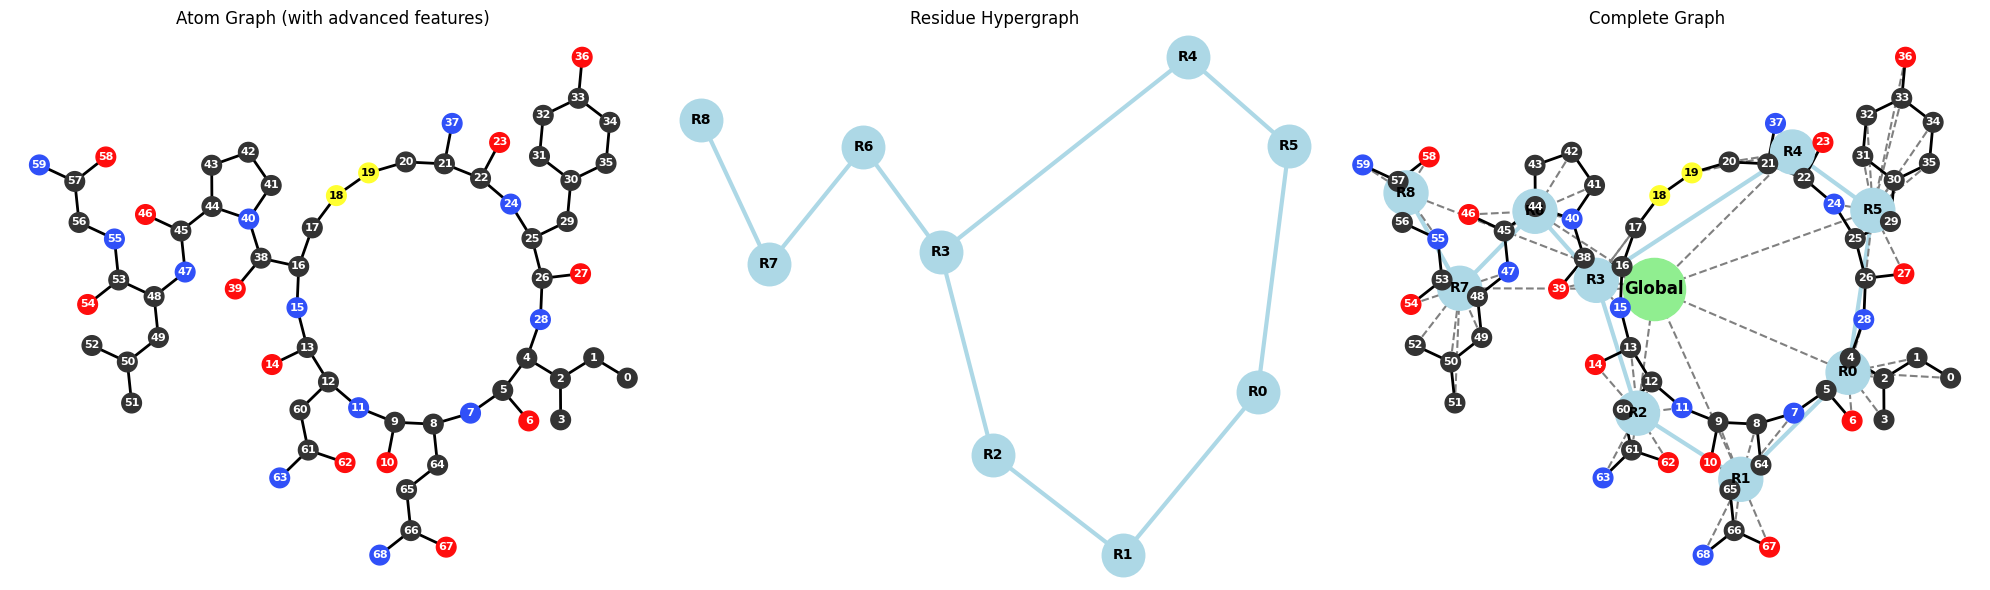

In [ ]:
# @title Graph Embedding

class GraphEmbedding:
    """Handles graph embedding for a peptide molecule with advanced featurization."""

    def __init__(self, peptide: Peptide):
        """Initializes a GraphEmbedding object.

        Args:
            peptide: The Peptide object to create embeddings for.
        """
        self.peptide = peptide
        self.mol = peptide.mol
        self.atom_graph = self._build_atom_graph()
        self.residue_graph = self._build_residue_graph()
        self.global_node = self._build_global_node()

    def _build_atom_graph(self) -> nx.Graph:
        """Builds a graph representation of atoms in the molecule with advanced features."""
        graph = nx.Graph()

        # Compute Gasteiger charges
        AllChem.ComputeGasteigerCharges(self.mol)

        for atom in self.mol.GetAtoms():
            features = self._get_atom_features(atom)
            graph.add_node(atom.GetIdx(), **features)

        for bond in self.mol.GetBonds():
            features = self._get_bond_features(bond)
            graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), **features)

        return graph

    def _get_atom_features(self, atom: Chem.Atom) -> dict:
        """Computes comprehensive features for an atom."""
        atom_features = {
            # Basic properties
            'atomic_num': atom.GetAtomicNum(),
            'degree': atom.GetDegree(),
            'total_degree': atom.GetTotalDegree(),
            'explicit_valence': atom.GetExplicitValence(),
            'implicit_valence': atom.GetImplicitValence(),
            'formal_charge': atom.GetFormalCharge(),
            'hybridization': int(atom.GetHybridization()),
            'total_num_Hs': atom.GetTotalNumHs(),
            'num_explicit_Hs': atom.GetNumExplicitHs(),
            'num_implicit_Hs': atom.GetNumImplicitHs(),
            'atomic_mass': atom.GetMass(),
            'isotope': atom.GetIsotope(),

            # Electronic properties
            'gasteiger_charge': atom.GetDoubleProp('_GasteigerCharge'),
            'default_valency': Chem.GetPeriodicTable().GetDefaultValence(atom.GetAtomicNum()),
            'num_radical_electrons': atom.GetNumRadicalElectrons(),

            # Topological properties
            'is_aromatic': int(atom.GetIsAromatic()),
            'is_in_ring': int(atom.IsInRing()),
            'is_in_ring_size_3': int(atom.IsInRingSize(3)),
            'is_in_ring_size_4': int(atom.IsInRingSize(4)),
            'is_in_ring_size_5': int(atom.IsInRingSize(5)),
            'is_in_ring_size_6': int(atom.IsInRingSize(6)),
            'is_in_ring_size_7': int(atom.IsInRingSize(7)),
            'num_rings': len(atom.GetOwningMol().GetRingInfo().AtomRings()),

            # Stereochemistry
            'chiral_tag': int(atom.GetChiralTag()),
            'chirality_type': str(atom.GetChiralTag()),
            'has_chiral_tag': int(atom.HasProp('_CIPCode')),

            # Contributions to molecular properties
            'crippen_contrib_logp': Crippen.MolLogP(self.mol) / self.mol.GetNumAtoms(),
            'crippen_contrib_mr': Crippen.MolMR(self.mol) / self.mol.GetNumAtoms(),
            'tpsa_contrib': rdMolDescriptors.CalcTPSA(self.mol) / self.mol.GetNumAtoms(),
            'labute_asa': float(rdMolDescriptors.CalcLabuteASA(self.mol)) / self.mol.GetNumAtoms(),

            # Environment features
            'num_neighbors': len([x for x in atom.GetNeighbors()]),
            'num_aromatic_bonds': len([b for b in atom.GetBonds() if b.GetIsAromatic()]),
            'num_single_bonds': len([b for b in atom.GetBonds() if b.GetBondType() == Chem.BondType.SINGLE]),
            'num_double_bonds': len([b for b in atom.GetBonds() if b.GetBondType() == Chem.BondType.DOUBLE]),
            'num_triple_bonds': len([b for b in atom.GetBonds() if b.GetBondType() == Chem.BondType.TRIPLE]),

            # Protein-specific features
            'is_backbone': int(atom.GetSymbol() in ['N', 'C', 'O'] and self._is_backbone_atom(atom)),
            'is_sidechain': int(not self._is_backbone_atom(atom)),
            'is_terminal': int(atom.GetDegree() == 1)
        }

        return atom_features

    def _get_bond_features(self, bond: Chem.Bond) -> dict:
        """Computes comprehensive features for a bond."""
        begin_atom = bond.GetBeginAtom()
        end_atom = bond.GetEndAtom()

        return {
            # Basic properties
            'bond_type': int(bond.GetBondType()),
            'bond_type_str': str(bond.GetBondType()),
            'is_conjugated': int(bond.GetIsConjugated()),
            'is_in_ring': int(bond.IsInRing()),
            'is_aromatic': int(bond.GetIsAromatic()),

            # Stereochemistry
            'stereo': int(bond.GetStereo()),
            'stereo_str': str(bond.GetStereo()),
            'is_stereochem': int(bond.GetStereo() != Chem.BondStereo.STEREONONE),

            # Rotatable bond
            'is_rotatable': int(self._is_rotatable_bond(bond)),

            # Topology
            'ring_size': min([len(ring) for ring in bond.GetOwningMol().GetRingInfo().BondRings()
                            if bond.GetIdx() in ring], default=0),

            # Bond environment
            'valence_contribution': bond.GetValenceContrib(begin_atom) + bond.GetValenceContrib(end_atom),
            'is_conjugated_to_aromatic': int(any(nb.GetIsAromatic() for nb in begin_atom.GetNeighbors()) or
                                        any(nb.GetIsAromatic() for nb in end_atom.GetNeighbors())),

            # Peptide-specific features
            'is_amide': int(self._is_secondary_amide(bond)),
            'is_peptoid': int(self._is_peptoid_bond(bond)),
            'is_disulfide': int(self._is_disulfide_bond(bond)),
            'is_backbone': int(self._is_secondary_amide(bond) or self._is_peptoid_bond(bond)),

            # Atom context
            'connects_aromatic': int(begin_atom.GetIsAromatic() and end_atom.GetIsAromatic()),
            'connects_ring': int(begin_atom.IsInRing() and end_atom.IsInRing()),
            'connects_different_rings': int(begin_atom.IsInRing() and end_atom.IsInRing() and
                                        not bond.IsInRing())
        }

    @staticmethod
    def _is_rotatable_bond(bond: Chem.Bond) -> bool:
        """Determines if a bond is rotatable."""
        return (not bond.IsInRing() and
                bond.GetBondType() == Chem.BondType.SINGLE and
                not bond.GetBeginAtom().GetAtomicNum() == 1 and
                not bond.GetEndAtom().GetAtomicNum() == 1)

    def _build_residue_graph(self) -> nx.Graph:
        """Builds a graph representation of residues in the molecule."""
        graph = nx.Graph()
        residue_bonds = self._get_residue_bonds()
        residues = self._get_residues(residue_bonds)

        for i, residue_atoms in enumerate(residues):
            backbone_atoms = self._get_backbone_atoms(residue_atoms)
            graph.add_node(f"R{i}", atoms=residue_atoms, backbone_atoms=backbone_atoms)

        for i, residue1 in enumerate(residues):
            for j, residue2 in enumerate(residues):
                if i != j and self._are_residues_connected(residue1, residue2):
                    graph.add_edge(f"R{i}", f"R{j}")

        return graph

    def _build_global_node(self) -> nx.Graph:
        """Builds a graph with a global node connected to all residues."""
        graph = nx.Graph()
        graph.add_node("Global")
        for node in self.residue_graph.nodes():
            graph.add_edge("Global", node)
        return graph

    def _get_backbone_atoms(self, residue_atoms: Set[int]) -> Set[int]:
        """Identifies backbone atoms in a residue."""
        backbone_atoms = set()
        for atom_idx in residue_atoms:
            atom = self.mol.GetAtomWithIdx(atom_idx)
            if atom.GetSymbol() in ['N', 'C', 'O']:
                if self._is_backbone_atom(atom):
                    backbone_atoms.add(atom_idx)
        return backbone_atoms

    @staticmethod
    def _is_backbone_atom(atom: Chem.Atom) -> bool:
        """Checks if an atom is part of the peptide backbone."""
        if atom.GetSymbol() == 'N':
            return any(n.GetSymbol() == 'C' for n in atom.GetNeighbors())
        elif atom.GetSymbol() == 'C':
            return any(n.GetSymbol() == 'N' for n in atom.GetNeighbors())
        elif atom.GetSymbol() == 'O':
            return any(n.GetSymbol() == 'C' for n in atom.GetNeighbors())
        return False

    def _get_residue_bonds(self) -> List[Chem.Bond]:
        """Identifies bonds that form residue boundaries."""
        return [bond for bond in self.mol.GetBonds() if self._is_residue_boundary(bond)]

    def _is_residue_boundary(self, bond: Chem.Bond) -> bool:
        """Checks if a bond forms a residue boundary."""
        return (self._is_secondary_amide(bond) or
                self._is_peptoid_bond(bond) or
                self._is_disulfide_bond(bond))

    def _is_secondary_amide(self, bond: Chem.Bond) -> bool:
        """Checks if a bond is a secondary amide bond."""
        begin_atom, end_atom = bond.GetBeginAtom(), bond.GetEndAtom()
        return (begin_atom.GetSymbol() == 'C' and end_atom.GetSymbol() == 'N' and
                self._is_carbonyl_carbon(begin_atom) and end_atom.GetTotalDegree() == 3)

    def _is_peptoid_bond(self, bond: Chem.Bond) -> bool:
        """Checks if a bond is a peptoid bond."""
        begin_atom, end_atom = bond.GetBeginAtom(), bond.GetEndAtom()
        return (begin_atom.GetSymbol() == 'C' and end_atom.GetSymbol() == 'N' and
                self._is_carbonyl_carbon(begin_atom) and end_atom.GetTotalDegree() == 3 and
                any(neighbor.GetSymbol() == 'C' for neighbor in end_atom.GetNeighbors() if neighbor != begin_atom))

    @staticmethod
    def _is_disulfide_bond(bond: Chem.Bond) -> bool:
        """Checks if a bond is a disulfide bond."""
        return (bond.GetBeginAtom().GetSymbol() == 'S' and
                bond.GetEndAtom().GetSymbol() == 'S' and
                bond.GetBondType() == Chem.BondType.SINGLE)

    def _get_residues(self, residue_bonds: List[Chem.Bond]) -> List[Set[int]]:
        """Identifies residues in the molecule."""
        all_residues = []
        visited_atoms = set()
        bond_atoms = set([atom.GetIdx() for bond in residue_bonds for atom in (bond.GetBeginAtom(), bond.GetEndAtom())])

        main_loop_residues = self._identify_residues(self.peptide.num_residues_in_main_loop, visited_atoms, bond_atoms)
        all_residues.extend(main_loop_residues)

        main_branch_residues = self._identify_residues(self.peptide.num_residues_in_branch, visited_atoms, bond_atoms)
        all_residues.extend(main_branch_residues)

        remaining_atoms = set(range(self.mol.GetNumAtoms())) - visited_atoms
        self._merge_remaining_atoms(remaining_atoms, all_residues)

        return all_residues

    def _identify_residues(self, num_residues: int, visited_atoms: Set[int], bond_atoms: Set[int]) -> List[Set[int]]:
        """Identifies a specified number of residues."""
        residues = []
        for _ in range(num_residues):
            start_atom = self._find_next_start_atom(visited_atoms, bond_atoms)
            if start_atom is None:
                break
            residue_atoms = self._get_residue_atoms(start_atom, visited_atoms, bond_atoms)
            residues.append(residue_atoms)
            visited_atoms.update(residue_atoms)
        return residues

    def _find_next_start_atom(self, visited_atoms: Set[int], bond_atoms: Set[int]) -> Chem.Atom:
        """Finds the next starting atom for residue identification."""
        for atom_idx in bond_atoms:
            if atom_idx not in visited_atoms:
                return self.mol.GetAtomWithIdx(atom_idx)
        return None

    def _get_residue_atoms(self, start_atom: Chem.Atom, visited_atoms: Set[int], bond_atoms: Set[int]) -> Set[int]:
        """Identifies atoms belonging to a residue starting from a given atom."""
        residue_atoms = set()
        stack = [start_atom.GetIdx()]

        while stack:
            atom_idx = stack.pop()
            if atom_idx not in residue_atoms and atom_idx not in visited_atoms:
                residue_atoms.add(atom_idx)
                atom = self.mol.GetAtomWithIdx(atom_idx)
                for neighbor in atom.GetNeighbors():
                    neighbor_idx = neighbor.GetIdx()
                    bond = self.mol.GetBondBetweenAtoms(atom_idx, neighbor_idx)
                    if not self._is_residue_boundary(bond):
                        if neighbor_idx not in visited_atoms and neighbor_idx not in residue_atoms:
                            stack.append(neighbor_idx)
        return residue_atoms

    def _merge_remaining_atoms(self, remaining_atoms: Set[int], all_residues: List[Set[int]]) -> None:
        """Merges remaining atoms with the closest residue."""
        for atom_idx in remaining_atoms:
            closest_residue = self._find_closest_residue(atom_idx, all_residues)
            if closest_residue is not None:
                closest_residue.add(atom_idx)

    def _find_closest_residue(self, atom_idx: int, residues: List[Set[int]]) -> Set[int]:
        """Finds the closest residue to a given atom."""
        atom = self.mol.GetAtomWithIdx(atom_idx)
        for neighbor in atom.GetNeighbors():
            for residue in residues:
                if neighbor.GetIdx() in residue:
                    return residue
        return None

    def _are_residues_connected(self, residue1: Set[int], residue2: Set[int]) -> bool:
        """Checks if two residues are connected."""
        return any(self.atom_graph.has_edge(atom1, atom2)
                   for atom1 in residue1
                   for atom2 in residue2)

    @staticmethod
    def _is_carbonyl_carbon(atom: Chem.Atom) -> bool:
        """Checks if an atom is a carbonyl carbon."""
        return (atom.GetSymbol() == 'C' and
                any(neighbor.GetSymbol() == 'O' and neighbor.GetTotalDegree() == 1
                    for neighbor in atom.GetNeighbors()))

    def _generate_2d_coordinates(self) -> Dict[int, Tuple[float, float]]:
        """Generates 2D coordinates for atoms in the molecule."""
        AllChem.Compute2DCoords(self.mol)
        return {atom.GetIdx(): (self.mol.GetConformer().GetAtomPosition(atom.GetIdx()).x,
                                self.mol.GetConformer().GetAtomPosition(atom.GetIdx()).y)
                for atom in self.mol.GetAtoms()}

    @staticmethod
    def _calculate_center_of_mass(positions: List[Tuple[float, float]]) -> Tuple[float, float]:
        """Calculates the center of mass for a set of positions."""
        return tuple(map(lambda x: sum(x) / len(x), zip(*positions)))

    def _get_backbone_positions(self, residue_atoms: Set[int]) -> List[Tuple[float, float]]:
        """Gets the positions of backbone atoms in a residue."""
        backbone_atoms = self._get_backbone_atoms(residue_atoms)
        coordinates = self._generate_2d_coordinates()
        return [coordinates[idx] for idx in backbone_atoms]

    def draw_graphs(self) -> None:
        """Draws the atom graph, residue graph, and combined graph."""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        self._draw_atom_graph(ax1)
        self._draw_residue_graph(ax2)
        self._draw_combined_graph(ax3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _get_cpk_color(atom_symbol: str) -> str:
        """Returns the CPK color for a given atom symbol."""
        cpk_colors = {
            'C': '#333333', 'N': '#3050F8', 'O': '#FF0D0D', 'H': '#FFFFFF',
            'S': '#FFFF30', 'Cl': '#1FF01F', 'B': '#F08080', 'P': '#FFA500',
            'Fe': '#FFA500', 'Ba': '#00C900', 'Na': '#AB5CF2'
        }
        return cpk_colors.get(atom_symbol, '#FFFFFF')

    @staticmethod
    def _get_label_color(background_color: str) -> str:
        """Determines the label color (black or white) based on background color brightness."""
        # Convert hex to RGB
        r = int(background_color[1:3], 16) / 255.0
        g = int(background_color[3:5], 16) / 255.0
        b = int(background_color[5:7], 16) / 255.0

        # Calculate luminance
        luminance = 0.299 * r + 0.587 * g + 0.114 * b

        # Use black for light backgrounds, white for dark backgrounds
        return '#000000' if luminance > 0.5 else '#FFFFFF'

    def _draw_atom_graph(self, ax: plt.Axes) -> None:
        """Draws the atom graph with adaptive label colors using scatter and text."""
        pos_atom = self._generate_2d_coordinates()
        node_colors = []
        label_colors = {}

        for node in self.atom_graph.nodes():
            atom_color = self._get_cpk_color(self.mol.GetAtomWithIdx(node).GetSymbol())
            node_colors.append(atom_color)
            label_colors[node] = self._get_label_color(atom_color)

        # Draw nodes using scatter
        node_positions = np.array([pos_atom[n] for n in self.atom_graph.nodes()])
        ax.scatter(node_positions[:, 0], node_positions[:, 1],
                   c=node_colors, s=200, zorder=2)

        # Draw edges using LineCollection
        edge_pos = [(pos_atom[e[0]], pos_atom[e[1]]) for e in self.atom_graph.edges()]
        edge_collection = mc.LineCollection(edge_pos, colors='k', linewidths=2, zorder=1)
        ax.add_collection(edge_collection)

        # Draw labels using matplotlib's text
        for node in self.atom_graph.nodes():
            x, y = pos_atom[node]
            label = str(node)
            ax.text(x, y, label, fontsize=8, color=label_colors[node],
                    ha='center', va='center', zorder=3, fontweight='bold')

        ax.set_title("Atom Graph (with advanced features)")
        ax.axis('off')

    def _draw_residue_graph(self, ax: plt.Axes) -> None:
        """Draws the residue graph using scatter and text."""
        residue_pos = {}
        for node in self.residue_graph.nodes():
            atoms = self.residue_graph.nodes[node]['atoms']
            backbone_positions = self._get_backbone_positions(atoms)
            residue_pos[node] = self._calculate_center_of_mass(backbone_positions)

        # Draw nodes using scatter
        node_positions = np.array([residue_pos[n] for n in self.residue_graph.nodes()])
        ax.scatter(node_positions[:, 0], node_positions[:, 1],
                   c='lightblue', s=1000, edgecolors='k', linewidths=0, zorder=2)

        # Draw edges using LineCollection
        edge_pos = [(residue_pos[e[0]], residue_pos[e[1]]) for e in self.residue_graph.edges()]
        edge_collection = mc.LineCollection(edge_pos, colors='lightblue', linewidths=3, zorder=1)
        ax.add_collection(edge_collection)

        # Draw labels using matplotlib's text
        for node in self.residue_graph.nodes():
            x, y = residue_pos[node]
            label = str(node)
            ax.text(x, y, label, fontsize=10, fontweight='bold', color='k',
                    ha='center', va='center', zorder=3)

        ax.set_title("Residue Hypergraph")
        ax.axis('off')

    def _draw_combined_graph(self, ax: plt.Axes) -> None:
        """Draws a combined graph with atoms, residues, and global node, layered appropriately."""
        combined_graph = nx.Graph()

        # Add atom nodes and edges
        atom_pos = self._generate_2d_coordinates()
        for atom in self.mol.GetAtoms():
            atom_color = self._get_cpk_color(atom.GetSymbol())
            label_color = self._get_label_color(atom_color)
            combined_graph.add_node(atom.GetIdx(), color=atom_color, label_color=label_color, node_type='atom', zorder=3)
        for bond in self.mol.GetBonds():
            combined_graph.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), color='k', edge_type='bond', zorder=2)

        # Add residue nodes and edges
        residue_pos = {}
        for i, (node, data) in enumerate(self.residue_graph.nodes(data=True)):
            atoms = data['atoms']
            backbone_positions = self._get_backbone_positions(atoms)
            residue_pos[node] = self._calculate_center_of_mass(backbone_positions)
            combined_graph.add_node(node, color='lightblue', label_color='black', alpha=1, node_type='residue', zorder=2)

            # Add semitransparent edges between residue and its atoms
            for atom in atoms:
                combined_graph.add_edge(node, atom, color='gray', alpha=1, style='dashed', edge_type='residue-atom', zorder=1)

        # Add edges between connected residues
        for edge in self.residue_graph.edges():
            combined_graph.add_edge(edge[0], edge[1], color='lightblue', style='solid', edge_type='residue-residue', zorder=1)

        # Add global node
        global_pos = self._calculate_center_of_mass(list(residue_pos.values()))
        combined_graph.add_node('Global', color='lightgreen', label_color='black', alpha=1, node_type='global', zorder=1)
        for node in self.residue_graph.nodes():
            combined_graph.add_edge('Global', node, color='gray', alpha=1, style='dashed', edge_type='global-residue', zorder=0)

        # Combine positions
        pos = {**atom_pos, **residue_pos, 'Global': global_pos}

        # Draw edges using LineCollection
        edge_types = ['global-residue', 'residue-residue', 'residue-atom', 'bond']
        for edge_type in edge_types:
            edges = [e for e in combined_graph.edges(data=True) if e[2]['edge_type'] == edge_type]
            if edges:
                edge_pos = [(pos[e[0]], pos[e[1]]) for e in edges]
                edge_collection = mc.LineCollection(edge_pos,
                                                    colors=[e[2]['color'] for e in edges],
                                                    alpha=[e[2].get('alpha', 1.0) for e in edges],
                                                    linestyles=[e[2].get('style', 'solid') for e in edges],
                                                    linewidths=1.5 if edge_type == "global-residue" else 1.5 if edge_type == "residue-atom" else 3 if edge_type == "residue-residue" else 2,
                                                    zorder=edges[0][2]['zorder'])
                ax.add_collection(edge_collection)

        # Draw nodes using scatter
        node_types = ['global', 'residue', 'atom']
        for node_type in node_types:
            nodes = [n for n, data in combined_graph.nodes(data=True) if data['node_type'] == node_type]
            if nodes:
                node_colors = [combined_graph.nodes[n]['color'] for n in nodes]
                node_sizes = [2000 if node_type == 'global' else 1000 if node_type == 'residue' else 200 for _ in nodes]
                node_positions = np.array([pos[n] for n in nodes])
                ax.scatter(node_positions[:, 0], node_positions[:, 1],
                        c=node_colors, s=node_sizes,
                        alpha=combined_graph.nodes[nodes[0]].get('alpha', 1.0),
                        zorder=combined_graph.nodes[nodes[0]]['zorder'])

        # Draw labels using matplotlib's text
        for node_type in node_types:
            nodes = [n for n, data in combined_graph.nodes(data=True) if data['node_type'] == node_type]
            font_size = 12 if node_type == 'global' else 10 if node_type == 'residue' else 8
            font_weight = 'bold'
            for node in nodes:
                x, y = pos[node]
                label = str(node)
                font_color = combined_graph.nodes[node]['label_color']
                ax.text(x, y, label, fontsize=font_size, fontweight=font_weight,
                        color=font_color, ha='center', va='center',
                        zorder=combined_graph.nodes[node]['zorder'] + 1)

        ax.set_title("Complete Graph")
        ax.axis('off')

    def to_pytorch_geometric(self):
        """Converts the molecular graph to PyTorch Geometric format with enhanced features."""
        # Convert atom features to node features
        node_features = []
        for node, data in self.atom_graph.nodes(data=True):
            features = [
                # Basic properties
                data['atomic_num'],
                data['degree'],
                data['total_degree'],
                data['explicit_valence'],
                data['implicit_valence'],
                data['formal_charge'],
                data['hybridization'],
                data['total_num_Hs'],
                data['num_explicit_Hs'],
                data['num_implicit_Hs'],
                data['atomic_mass'],
                data['isotope'],

                # Electronic properties
                data['gasteiger_charge'],
                data['default_valency'],
                data['num_radical_electrons'],

                # Topological properties
                data['is_aromatic'],
                data['is_in_ring'],
                data['is_in_ring_size_3'],
                data['is_in_ring_size_4'],
                data['is_in_ring_size_5'],
                data['is_in_ring_size_6'],
                data['is_in_ring_size_7'],
                data['num_rings'],

                # Stereochemistry
                data['chiral_tag'],
                data['has_chiral_tag'],

                # Contributions to molecular properties
                data['crippen_contrib_logp'],
                data['crippen_contrib_mr'],
                data['tpsa_contrib'],
                data['labute_asa'],

                # Environment features
                data['num_neighbors'],
                data['num_aromatic_bonds'],
                data['num_single_bonds'],
                data['num_double_bonds'],
                data['num_triple_bonds'],

                # Protein-specific features
                data['is_backbone'],
                data['is_sidechain'],
                data['is_terminal']
            ]
            node_features.append(features)
        node_features = torch.tensor(node_features, dtype=torch.float)

        # Convert bonds to edge indices and features
        edge_index = []
        edge_features = []
        for u, v, data in self.atom_graph.edges(data=True):
            # Add both directions for undirected graph
            edge_index.extend([[u, v], [v, u]])

            features = [
                # Basic properties
                data['bond_type'],
                data['is_conjugated'],
                data['is_in_ring'],
                data['is_aromatic'],

                # Stereochemistry
                data['stereo'],
                data['is_stereochem'],

                # Topology
                data['is_rotatable'],
                data['ring_size'],

                # Bond environment
                data['valence_contribution'],
                data['is_conjugated_to_aromatic'],

                # Peptide-specific features
                data['is_amide'],
                data['is_peptoid'],
                data['is_disulfide'],
                data['is_backbone'],

                # Atom context
                data['connects_aromatic'],
                data['connects_ring'],
                data['connects_different_rings']
            ]
            # Add features for both directions
            edge_features.extend([features, features])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_features = torch.tensor(edge_features, dtype=torch.float)

        # Enhanced residue features
        residue_features = []
        for node, data in self.residue_graph.nodes(data=True):
            atoms = data['atoms']
            backbone_atoms = data['backbone_atoms']

            # Calculate additional residue-level features
            aromatic_atoms = sum(1 for atom_idx in atoms
                            if self.mol.GetAtomWithIdx(atom_idx).GetIsAromatic())
            ring_atoms = sum(1 for atom_idx in atoms
                            if self.mol.GetAtomWithIdx(atom_idx).IsInRing())
            charged_atoms = sum(1 for atom_idx in atoms
                            if self.mol.GetAtomWithIdx(atom_idx).GetFormalCharge() != 0)

            features = [
                len(atoms),                    # Total atoms in residue
                len(backbone_atoms),           # Number of backbone atoms
                aromatic_atoms,                # Number of aromatic atoms
                ring_atoms,                    # Number of atoms in rings
                charged_atoms,                 # Number of charged atoms
                len(atoms - backbone_atoms),   # Number of side chain atoms
                float(len(backbone_atoms)) / len(atoms)  # Backbone ratio
            ]
            residue_features.append(features)
        residue_features = torch.tensor(residue_features, dtype=torch.float)

        # Enhanced global features
        global_features = torch.tensor([
            self.peptide.num_residues,
            self.peptide.num_residues_in_main_loop,
            self.peptide.num_residues_in_branch,
            self.mol.GetNumAtoms(),           # Total number of atoms
            self.mol.GetNumBonds(),           # Total number of bonds
            rdMolDescriptors.CalcNumRings(self.mol),  # Total number of rings
            rdMolDescriptors.CalcNumRotatableBonds(self.mol),  # Number of rotatable bonds
            rdMolDescriptors.CalcNumAromaticRings(self.mol),   # Number of aromatic rings
            float(len([a for a in self.mol.GetAtoms() if a.GetIsAromatic()])) / self.mol.GetNumAtoms(),  # Aromatic ratio
            Crippen.MolLogP(self.mol),        # Molecular LogP
            rdMolDescriptors.CalcTPSA(self.mol)  # Total polar surface area
        ], dtype=torch.float).unsqueeze(0)

        return Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_features,
            residue_x=residue_features,
            global_x=global_features
        )

oxytocin = "CC[C@H](C)[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CSSC[C@@H](C(=O)N[C@H](C(=O)N1)CC2=CC=C(C=C2)O)N)C(=O)N3CCC[C@H]3C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N)CC(=O)N)CCC(=O)N"
oxytocin_num_residues = 9
oxytocin_num_residues_in_main_loop = 6

peptide = Peptide(oxytocin, oxytocin_num_residues, oxytocin_num_residues_in_main_loop)
peptide.draw_graphs()


In [ ]:
# @title Data Augmenter

class GraphDatasetAugmenter:
    def __init__(self, dataset, num_bins=20, target_number=1000, permutations_per_graph=1000, scaler=None):
        """
        Initialize the augmenter with either a PeptideDataset instance or a list of PyG Data objects.

        Args:
            dataset: Either a PeptideDataset instance or a list of PyG Data objects
            num_bins: Number of bins to divide the PAMPA value range into
            permutations_per_graph: Base number of permutations per graph
            scaler: Optional scaler for inverse transform of y values
        """
        self.dataset = dataset
        self.num_bins = num_bins
        self.permutations_per_graph = permutations_per_graph
        self.y_scaler = scaler

        # Handle different dataset types
        if hasattr(dataset, 'processed_data'):
            self.data_list = dataset.processed_data
        else:
            self.data_list = dataset

        # Get original PAMPA values (unscaled)
        self.pampa_values = []
        for data in self.data_list:
            y_value = data.y.cpu().numpy()
            if self.y_scaler is not None:
                # Reshape for scaler which expects 2D input
                y_value = y_value.reshape(-1, 1)
                y_value = self.y_scaler.inverse_transform(y_value).flatten()
            self.pampa_values.append(y_value[0])
        self.pampa_values = np.array(self.pampa_values)

        # Create bins using unscaled values
        self.bins = np.linspace(
            self.pampa_values.min(),
            self.pampa_values.max(),
            num_bins + 1
        )
        self.bin_indices = np.digitize(self.pampa_values, self.bins) - 1

        # Count samples in each bin
        self.bin_counts = np.bincount(self.bin_indices, minlength=num_bins)

        # Set target count to the maximum bin count
        self.target_count = np.max([int(np.max(self.bin_counts)), target_number])

    def plot_distribution(self, include_augmented=True):
        """
        Plot the distribution of PAMPA values before and after augmentation.
        All values are plotted in their original unscaled form.
        """
        plt.figure(figsize=(9, 4))

        if include_augmented:
            augmented_data = self.augment()
            augmented_values = []

            # Unscale augmented values
            for data in augmented_data:
                y_value = data.y.cpu().numpy()
                if self.y_scaler is not None:
                    y_value = y_value.reshape(-1, 1)
                    y_value = self.y_scaler.inverse_transform(y_value).flatten()
                augmented_values.append(y_value[0])
            augmented_values = np.array(augmented_values)

            # Plot augmented first (so original is on top)
            plt.hist(augmented_values, bins=self.bins, alpha=0.5,
                    label='Augmented', color='orange')

            # Print statistics using unscaled values
            print("\nBin Statistics (Original Scale):")
            hist, _ = np.histogram(augmented_values, bins=self.bins)
            for i, (count, bin_edge) in enumerate(zip(hist, self.bins[:-1])):
                print(f"Bin {i} ({bin_edge:.2f} to {self.bins[i+1]:.2f}): {count} samples")

        # Plot original values (already unscaled in self.pampa_values)
        plt.hist(self.pampa_values, bins=self.bins, alpha=0.5,
                label='Original', color='skyblue')

        plt.xlabel('PAMPA Value (Original Scale)')
        plt.ylabel('Frequency')
        plt.title('Distribution of PAMPA Values')
        plt.legend()
        plt.show()

        # Print additional statistics
        print("\nDistribution Statistics (Original Scale):")
        print(f"Original data range: {self.pampa_values.min():.2f} to {self.pampa_values.max():.2f}")
        if include_augmented:
            print(f"Augmented data range: {augmented_values.min():.2f} to {augmented_values.max():.2f}")
            print(f"Total samples - Original: {len(self.pampa_values)}, Augmented: {len(augmented_values)}")

    def permute_graph(self, graph_data):
        """
        Create a permuted version of the input graph while preserving its structure and edge attributes.
        """
        device = graph_data.x.device
        num_nodes = graph_data.x.size(0)

        # Generate random permutation
        perm = torch.randperm(num_nodes, device=device)

        # Create inverse permutation mapping
        inv_perm = torch.zeros_like(perm)
        inv_perm[perm] = torch.arange(num_nodes, device=device)

        # Permute node features and edge indices
        new_x = graph_data.x[perm]
        new_edge_index = graph_data.edge_index.clone()
        new_edge_index = inv_perm[new_edge_index]

        # Create new graph with all attributes
        new_data = {
            'x': new_x,
            'edge_index': new_edge_index,
            'y': graph_data.y.clone()
        }

        # Copy edge attributes if they exist
        if hasattr(graph_data, 'edge_attr'):
            new_data['edge_attr'] = graph_data.edge_attr.clone()

        # Copy any additional attributes from the original graph
        for key in graph_data.keys():
            if key not in ['x', 'edge_index', 'edge_attr', 'y']:
                new_data[key] = graph_data[key]

        return Data(**new_data)

    def augment(self):
        """
        Perform dataset augmentation to match all bins to the size of the largest bin.
        """
        augmented_data = []

        # Group original data by bins
        bin_to_graphs = defaultdict(list)
        for idx, bin_idx in enumerate(self.bin_indices):
            bin_to_graphs[bin_idx].append(self.data_list[idx])

        # Find non-empty bins
        non_empty_bins = [i for i in range(self.num_bins) if self.bin_counts[i] > 0]

        # For each non-empty bin that needs augmentation
        for bin_idx in non_empty_bins:
            current_count = self.bin_counts[bin_idx]
            samples_needed = self.target_count - current_count

            if samples_needed <= 0:
                continue

            graphs_in_bin = bin_to_graphs[bin_idx]

            # Calculate permutations needed per graph
            perms_per_graph = int(np.ceil(samples_needed / len(graphs_in_bin)))

            # Generate samples
            samples_generated = 0
            while samples_generated < samples_needed:
                for graph in graphs_in_bin:
                    if samples_generated >= samples_needed:
                        break

                    augmented_data.append(self.permute_graph(graph))
                    samples_generated += 1

                    # If we've used all graphs but still need more samples,
                    # start over with the same graphs
                    if samples_generated < samples_needed and graph == graphs_in_bin[-1]:
                        continue
        augmented_data = augmented_data + self.data_list
        return augmented_data

    def get_augmented_dataset(self):
        """
        Returns a new dataset containing both original and augmented samples.
        """
        augmented_data = self.augment()
        return self.data_list + augmented_data

In [ ]:
# @title Peptide Dataset

class PeptideDataset(Dataset):
    def __init__(self, csv_file, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        self.data = pd.read_csv(csv_file)
        self.processed_data = []
        self._indices = None
        self.y_scaler = StandardScaler()
        self.node_feature_scaler = StandardScaler()
        self._process()

    def _process(self):
        all_pampa_values = self.data['PAMPA'].values.reshape(-1, 1)
        self.y_scaler.fit(all_pampa_values)

        all_node_features = []

        for _, row in tqdm(self.data.iterrows(), desc="Processing data"):
            smiles = row['SMILES']
            pampa = row['PAMPA']
            num_residues = row['Num Residues']
            num_residues_in_main_loop = row['Num Residues in Main Cycle']

            peptide = Peptide(smiles, num_residues=num_residues, num_residues_in_main_loop=num_residues_in_main_loop)
            graph_data = peptide.graph_embedding.to_pytorch_geometric()

            all_node_features.append(graph_data.x.numpy())

        # Fit node feature scaler
        self.node_feature_scaler.fit(np.vstack(all_node_features))

        # Transform data
        for i, (_, row) in enumerate(tqdm(self.data.iterrows(), desc="Transforming data")):
            smiles = row['SMILES']
            pampa = row['PAMPA']
            num_residues = row['Num Residues']
            num_residues_in_main_loop = row['Num Residues in Main Cycle']

            peptide = Peptide(smiles, num_residues=num_residues, num_residues_in_main_loop=num_residues_in_main_loop)
            graph_data = peptide.graph_embedding.to_pytorch_geometric()

            # Scale PAMPA value
            scaled_pampa = self.y_scaler.transform([[pampa]])[0][0]
            graph_data.y = torch.tensor([scaled_pampa], dtype=torch.float)

            # Scale node features
            graph_data.x = torch.tensor(self.node_feature_scaler.transform(all_node_features[i]), dtype=torch.float)

            if self.pre_filter is not None and not self.pre_filter(graph_data):
                continue
            if self.pre_transform is not None:
                graph_data = self.pre_transform(graph_data)

            self.processed_data.append(graph_data)

    def len(self):
        return len(self.processed_data)

    def get(self, idx):
        return self.processed_data[idx]

    def clean(self, pampa_lower_bound=-8):
        """Removes peptides with PAMPA values below the specified lower bound."""
        original_pampa_values = self.y_scaler.inverse_transform(np.array([data.y.item() for data in self.processed_data]).reshape(-1, 1))
        self.processed_data = [data for data, original_pampa in zip(self.processed_data, original_pampa_values) if original_pampa[0] >= pampa_lower_bound]
        self.data = self.data[self.data['PAMPA'] >= pampa_lower_bound]
        self.data.reset_index(drop=True, inplace=True)

    def inverse_transform_y(self, y):
        """Inverse transform scaled y values to original scale."""
        return self.y_scaler.inverse_transform(y.reshape(-1, 1)).flatten()

In [ ]:
# @title Load Data

input_file = "/content/drive/MyDrive/Aa_Lokey_Lab/cyclic_peptide_training_set.csv" # @param {type:"string"}

dataset = PeptideDataset(input_file)
dataset.clean()

print(f"Number of peptides in the dataset: {len(dataset)}")

Processing data: 0it [00:00, ?it/s]

Transforming data: 0it [00:00, ?it/s]

Number of peptides in the dataset: 6606


In [ ]:
# @title Model

class MultiheadAttention(nn.Module):
    def __init__(self, hidden_channels, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.hidden_channels = hidden_channels
        self.head_dim = hidden_channels // num_heads

        self.q_proj = Linear(hidden_channels, hidden_channels)
        self.k_proj = Linear(hidden_channels, hidden_channels)
        self.v_proj = Linear(hidden_channels, hidden_channels)
        self.o_proj = Linear(hidden_channels, hidden_channels)
        self.dropout = Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)
        q = self.q_proj(x).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, -1, self.num_heads, self.head_dim)

        attention = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)

        out = torch.matmul(attention, v)
        out = out.view(batch_size, -1, self.hidden_channels)
        out = self.o_proj(out)
        return out

class DotProductAttention(nn.Module):
    def __init__(self, hidden_channels, dropout=0.1):
        super().__init__()
        self.dropout = Dropout(dropout)
        self.scale = math.sqrt(hidden_channels)

    def forward(self, x):
        attention = torch.matmul(x, x.transpose(-2, -1)) / self.scale
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)
        return torch.matmul(attention, x)

class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_channels, dropout=0.1):
        super().__init__()
        self.dropout = Dropout(dropout)
        self.scale = math.sqrt(hidden_channels)

    def forward(self, q, k, v, mask=None):
        attention = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e9)
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)
        return torch.matmul(attention, v)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_channels, dropout=0.1):
        super().__init__()
        self.query_proj = Linear(hidden_channels, hidden_channels)
        self.key_proj = Linear(hidden_channels, hidden_channels)
        self.value_proj = Linear(hidden_channels, 1)
        self.dropout = Dropout(dropout)

    def forward(self, x):
        q = self.query_proj(x)
        k = self.key_proj(x)
        scores = self.value_proj(torch.tanh(q + k))
        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)
        return torch.matmul(attention.transpose(-2, -1), x)

class BilinearAttention(nn.Module):
    def __init__(self, hidden_channels, dropout=0.1):
        super().__init__()
        self.weight = nn.Parameter(torch.Tensor(hidden_channels, hidden_channels))
        self.dropout = Dropout(dropout)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        attention = torch.matmul(torch.matmul(x, self.weight), x.transpose(-2, -1))
        attention = F.softmax(attention, dim=-1)
        attention = self.dropout(attention)
        return torch.matmul(attention, x)

class GlobalAttentionPooling(nn.Module):
    def __init__(self, hidden_channels, num_heads):
        super().__init__()
        self.attention = MultiheadAttention(hidden_channels, num_heads)

    def forward(self, x, batch):
        attention_output = self.attention(x)
        return global_add_pool(attention_output, batch)

class TopKPooling(nn.Module):
    def __init__(self, hidden_channels, ratio=0.8):
        super().__init__()
        self.ratio = ratio
        self.topk = TopKPooling(hidden_channels, ratio=ratio)

    def forward(self, x, edge_index, batch):
        pooled_output = self.topk(x, edge_index, batch)
        return pooled_output[0]

class ResidualFusion(nn.Module):
    def __init__(self, hidden_channels, residual_features, fusion_type='cross_attention'):
        super().__init__()
        self.fusion_type = fusion_type
        self.fusion_layer = nn.Linear(hidden_channels + residual_features, hidden_channels)

    def forward(self, x, residual_features):
        if self.fusion_type == 'cross_attention':
            return self.fusion_layer(torch.cat([x, residual_features], dim=-1))

        elif self.fusion_type == 'dense':
            return self.fusion_layer(torch.cat([x, residual_features], dim=-1))

        else:
            raise ValueError(f"Unsupported fusion type: {self.fusion_type}")

class HybridPooling(nn.Module):
    def __init__(self, attention_pool, topk_pool, set2set_pool):
        super().__init__()
        self.attention_pool = attention_pool
        self.topk_pool = topk_pool
        self.set2set_pool = set2set_pool

    def forward(self, x, edge_index, batch):
        # Combine different pooling methods
        x1 = self.attention_pool(x, batch)
        x2 = self.topk_pool(x, edge_index, batch)[0]
        x3 = self.set2set_pool(x, batch)
        return torch.cat([x1, x2, x3], dim=-1)

class PositionalEncoding(nn.Module):
    """Flexible positional encoding module using PyTorch Geometric's implementations."""
    def __init__(
        self,
        hidden_channels: int,
        pe_type: str = 'laplacian',  # ['laplacian', 'random_walk', 'none']
        num_pe_features: int = 16,
        walk_length: int = 8,
        is_undirected: bool = False
    ):
        super().__init__()
        self.pe_type = pe_type
        self.hidden_channels = hidden_channels

        if pe_type == 'laplacian':
            self.pe_encoder = AddLaplacianEigenvectorPE(
                k=num_pe_features,
                attr_name='pe',  # Store PE in separate attribute
                is_undirected=is_undirected
            )
            self.pe_dim = num_pe_features
        elif pe_type == 'random_walk':
            self.pe_encoder = AddRandomWalkPE(
                walk_length=walk_length,
                attr_name='pe'  # Store PE in separate attribute
            )
            self.pe_dim = walk_length
        else:
            self.pe_encoder = None
            self.pe_dim = 0

        if pe_type != 'none':
            # Project PE to hidden dimension
            self.pe_projection = nn.Linear(self.pe_dim, hidden_channels)
            self.layer_norm = nn.LayerNorm(hidden_channels)

    def forward(self, x, edge_index, batch):
        if self.pe_type == 'none':
            return x

        # Create temporary Data object for PE computation
        temp_data = Data(
            x=x,
            edge_index=edge_index,
            batch=batch,
            num_nodes=x.size(0)
        )

        # Compute PE
        temp_data = self.pe_encoder(temp_data)

        # Get PE features and project them
        pe = self.pe_projection(temp_data.pe)
        pe = self.layer_norm(pe)

        # Add PE to input features
        x = x + pe

        return x

class ModularGraphAttentionTransformer(nn.Module):
    def __init__(self, node_features, edge_features, hidden_channels, **kwargs):
        super().__init__()
        # Store config
        self.config = {k: v for k, v in locals().items() if k != 'self'}
        self.config.update(kwargs)

        # Initialize components
        self.hidden_channels = hidden_channels
        self.edge_features = edge_features
        self.use_edge_features = kwargs.get('use_edge_features', False) and edge_features > 0
        self.num_heads = kwargs.get('num_heads', 8)

        # Initial node embedding
        self.node_embedding = nn.Sequential(
            nn.Linear(node_features, hidden_channels),
            nn.GELU(),
            nn.BatchNorm1d(hidden_channels)
        )

        # Edge embedding if using edge features
        if self.use_edge_features:
            self.edge_embedding = nn.Sequential(
                nn.Linear(edge_features, hidden_channels),
                nn.GELU(),
                nn.BatchNorm1d(hidden_channels)
            )

        # Main GAT layers
        self.layers = nn.ModuleList()
        for _ in range(kwargs.get('num_layers', 4)):
            layer = GATConv(
                in_channels=hidden_channels,
                out_channels=hidden_channels // self.num_heads,
                heads=self.num_heads,
                dropout=kwargs.get('dropout', 0.1),
                edge_dim=hidden_channels if self.use_edge_features else None,
                concat=True,
                add_self_loops=True
            )
            self.layers.append(layer)

        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.BatchNorm1d(hidden_channels) for _ in range(kwargs.get('num_layers', 4))
        ])

        # Attention pooling
        self.pool = AttentionalAggregation(
            gate_nn=nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.GELU(),
                nn.Linear(hidden_channels, 1)
            ),
            nn=None  # No transform needed as we already have hidden_channels dimension
        )

        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 2),
            nn.GELU(),
            nn.Dropout(kwargs.get('dropout', 0.1)),
            nn.Linear(hidden_channels * 2, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Initial node embedding
        x = self.node_embedding(x)

        # Process edge features if present
        edge_attr = None
        if self.use_edge_features and hasattr(data, 'edge_attr'):
            edge_attr = self.edge_embedding(data.edge_attr)

        # Main layers
        for layer, norm in zip(self.layers, self.layer_norms):
            # Apply GAT layer
            x_res = x  # Store residual
            x = layer(x, edge_index, edge_attr=edge_attr)
            x = norm(x)
            x = F.gelu(x)
            x = x + x_res  # Add residual

        # Global pooling
        x = self.pool(x, batch)

        # Output projection
        return self.output_layers(x)

def create_model(input_dim, edge_dim, hidden_channels=256, num_heads=8, num_layers=6):
    # Make sure edge_dim is correctly passed through
    edge_features = edge_dim if edge_dim is not None else 0

    model = ModularGraphAttentionTransformer(
        node_features=input_dim,
        edge_features=edge_features,
        hidden_channels=hidden_channels,
        num_heads=num_heads,
        num_layers=num_layers,
        dropout=0.1,
        attention_type='multihead',
        message_passing='gat',
        pooling_strategy='attention',
        activation='gelu',
        norm_type='batch',
        residual_mode='dense',
        position_encoding=True,
        pe_type='laplacian',
        num_pe_features=16,
        walk_length=8,
        is_undirected=True,
        edge_dim=edge_features,  # Pass the actual edge dimension
        virtual_nodes=False,
        ffn_ratio=4,
        pooling_ratio=0.5,
        use_edge_features=edge_features > 0,
        residual_features=None
    )
    return model

def evaluate_model(model, loader, criterion, device, dataset):
    model.eval()
    total_loss = 0
    total_mse = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch).squeeze()
            loss = criterion(out, batch.y.squeeze())
            total_loss += loss.item() * batch.num_graphs

            # Unscale predictions and targets for MSE calculation
            unscaled_out = dataset.inverse_transform_y(out.cpu().numpy())
            unscaled_y = dataset.inverse_transform_y(batch.y.squeeze().cpu().numpy())
            total_mse += mean_squared_error(unscaled_y, unscaled_out) * batch.num_graphs

            predictions.extend(unscaled_out)
            targets.extend(unscaled_y)

    avg_loss = total_loss / len(loader.dataset)
    avg_mse = total_mse / len(loader.dataset)
    r2 = r2_score(targets, predictions)

    return avg_loss, avg_mse, r2, np.array(predictions), np.array(targets)


In [ ]:
# @title Helpers

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def plot_learning_curves(train_losses, val_losses, train_mses, val_mses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Losses')
    ax1.legend()

    # Plot MSEs
    ax2.plot(train_mses, label='Train MSE')
    ax2.plot(val_mses, label='Validation MSE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.set_title('Training and Validation MSE')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_true_vs_predicted_and_residuals(targets, predictions, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # True vs Predicted
    ax1.scatter(targets, predictions, alpha=0.5)
    ax1.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--')
    ax1.set_xlabel('True Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title(f'{title} - True vs Predicted')

    # Residuals
    residuals = np.array(predictions) - np.array(targets)
    ax2.scatter(predictions, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{title} - Residuals Plot')

    plt.tight_layout()
    plt.show()

def calculate_metrics(predictions, targets):
    """Calculate multiple regression metrics."""
    predictions = np.array(predictions)
    targets = np.array(targets)

    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    targets = []

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y.squeeze())

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        predictions.extend(out.squeeze().detach().cpu().numpy())
        targets.extend(batch.y.squeeze().cpu().numpy())

    metrics = calculate_metrics(predictions, targets)
    return total_loss / len(loader.dataset), metrics, predictions, targets

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    targets = []

    for batch in loader:
        # Move entire batch to device
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y.squeeze())

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        predictions.extend(out.squeeze().detach().cpu().numpy())
        targets.extend(batch.y.squeeze().cpu().numpy())

    metrics = calculate_metrics(predictions, targets)
    return total_loss / len(loader.dataset), metrics, predictions, targets

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for batch in loader:
            # Move entire batch to device
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out.squeeze(), batch.y.squeeze())

            total_loss += loss.item() * batch.num_graphs
            predictions.extend(out.squeeze().cpu().numpy())
            targets.extend(batch.y.squeeze().cpu().numpy())

    metrics = calculate_metrics(predictions, targets)
    return total_loss / len(loader.dataset), metrics, predictions, targets

def setup_training(dataset, node_features, edge_features, config):
    """Setup all training components."""
    # Split dataset
    train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
    train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.3, random_state=42)

    print(f"\nDataset splits:")
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
    print(f"\nFeatures:")
    print(f"Number of node features: {node_features}")
    print(f"Number of edge features: {edge_features}")

    # Setup device first
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    # Create dataloaders with pin_memory for faster data transfer to GPU
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                            shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                          pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'],
                           pin_memory=True)

    # Initialize model
    model = ModularGraphAttentionTransformer(
        node_features=node_features,
        edge_features=edge_features,
        hidden_channels=config['hidden_channels'],
        num_heads=config['num_heads'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        attention_type='multihead',
        message_passing='gat',
        pooling_strategy='attention',
        use_edge_features=True
    ).to(device)  # Move model to device immediately after initialization

    # Print model configuration
    print_model_config(model)

    # Setup training components
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=10,
        min_lr=config['min_lr']
    )

    early_stopping = EarlyStopping(patience=20)

    return {
        'model': model,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'criterion': criterion,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'early_stopping': early_stopping,
        'device': device
    }

def plot_metrics_history(history):
    """Plot detailed training history including all metrics."""
    metrics = ['mse', 'rmse', 'mae', 'r2']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        train_metric = [epoch_metrics[metric] for epoch_metrics in history['train_metrics_history']]
        val_metric = [epoch_metrics[metric] for epoch_metrics in history['val_metrics_history']]

        ax.plot(train_metric, label=f'Train {metric.upper()}')
        ax.plot(val_metric, label=f'Val {metric.upper()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.upper())
        ax.set_title(f'{metric.upper()} over Training')
        ax.legend()

    plt.tight_layout()
    plt.show()

def print_model_config(model):
    """Print model configuration and parameters."""
    print("\nModel Configuration:")
    for key, value in model.config.items():
        print(f"{key}: {value}")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

def main_training_loop(dataset, node_features, edge_features, config):
    """Main training function that orchestrates the entire training process."""

    # Setup all components
    training_setup = setup_training(dataset, node_features, edge_features, config)

    # Train model
    results = train_model(
        model=training_setup['model'],
        train_loader=training_setup['train_loader'],
        val_loader=training_setup['val_loader'],
        criterion=training_setup['criterion'],
        optimizer=training_setup['optimizer'],
        scheduler=training_setup['scheduler'],
        device=training_setup['device'],
        early_stopping=training_setup['early_stopping']
    )

    # Evaluate on test set
    test_loss, test_metrics, test_predictions, test_targets = evaluate(
        model=training_setup['model'],
        loader=training_setup['test_loader'],
        criterion=training_setup['criterion'],
        device=training_setup['device']
    )

    # Print final results
    print("\nTest Set Results:")
    for metric, value in test_metrics.items():
        print(f"{metric.upper()}: {value:.4f}")

    # Plot results
    plot_metrics_history(results)
    plot_true_vs_predicted_and_residuals(
        results['val_targets'],
        results['val_predictions'],
        "Validation Set"
    )
    plot_true_vs_predicted_and_residuals(
        test_targets,
        test_predictions,
        "Test Set"
    )

    # Save model
    save_path = 'graph_transformer_model.pt'
    torch.save({
        'model_state_dict': training_setup['model'].state_dict(),
        'optimizer_state_dict': training_setup['optimizer'].state_dict(),
        'scheduler_state_dict': training_setup['scheduler'].state_dict(),
        'config': training_setup['model'].config,
        'results': results,
        'test_metrics': test_metrics
    }, save_path)
    print(f"\nModel saved to {save_path}")

    return training_setup['model'], results, test_metrics


In [ ]:
# @title Model Trainer

class ModelTrainer:
    def __init__(self, config):
        self.config = config
        self.device = config['device']
        self.y_scaler = None

    def process_batch(self, batch):
        """Process a batch ensuring all tensors are on the correct device."""
        if not hasattr(batch, 'batch'):
            batch.batch = torch.zeros(batch.x.size(0), dtype=torch.long)

        # List of attributes to check and move to device
        attributes = ['x', 'edge_index', 'edge_attr', 'y', 'batch']

        for attr in attributes:
            if hasattr(batch, attr):
                value = getattr(batch, attr)
                if torch.is_tensor(value):
                    setattr(batch, attr, value.to(self.device))

        return batch

    def prepare_dataset(self, dataset):
        """Split dataset and create dataloaders."""
        # Move dataset to CPU first to ensure consistent starting point

        dataset = [data.cpu() for data in dataset]

        train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
        train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.25, random_state=42)

        augmenter = GraphDatasetAugmenter(
            dataset=train_dataset,
            num_bins=20,
            target_number=1000,
            permutations_per_graph=1000,
            scaler = self.y_scaler
        )

        # Visualize the original distribution
        augmenter.plot_distribution(include_augmented=False)

        # Get the augmented dataset
        train_dataset = augmenter.get_augmented_dataset()

        # Visualize the distribution after augmentation
        augmenter.plot_distribution(include_augmented=True)

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config['batch_size'],
            shuffle=True,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config['batch_size'],
            shuffle=False,
            pin_memory=True if torch.cuda.is_available() else False
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=self.config['batch_size'],
            shuffle=False,
            pin_memory=True if torch.cuda.is_available() else False
        )

        return train_loader, val_loader, test_loader

    def unscale_values(self, values):
        """Unscale values using the stored scaler."""
        if self.y_scaler is None:
            raise ValueError("Scaler has not been initialized. Please call y_scaler() first.")

        # Reshape to 2D array if needed (scaler expects 2D input)
        values_2d = np.array(values).reshape(-1, 1)
        unscaled_values = self.y_scaler.inverse_transform(values_2d).flatten()
        return unscaled_values

    def train_epoch(self, model, loader, criterion, optimizer):
        """Train for one epoch."""
        model.train()
        total_loss = 0
        predictions = []
        targets = []

        for batch in loader:
            batch = self.process_batch(batch)
            optimizer.zero_grad()

            out = model(batch)
            loss = criterion(out.squeeze(), batch.y.squeeze())

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.num_graphs
            predictions.extend(out.squeeze().detach().cpu().numpy())
            targets.extend(batch.y.squeeze().cpu().numpy())

        # Unscale before computing metrics
        unscaled_predictions = self.unscale_values(predictions)
        unscaled_targets = self.unscale_values(targets)
        metrics = calculate_metrics(unscaled_predictions, unscaled_targets)

        return total_loss / len(loader.dataset), metrics, unscaled_predictions, unscaled_targets

    def evaluate(self, model, loader, criterion):
        """Evaluate the model."""
        model.eval()
        total_loss = 0
        predictions = []
        targets = []

        with torch.no_grad():
            for batch in loader:
                batch = self.process_batch(batch)
                out = model(batch)
                loss = criterion(out.squeeze(), batch.y.squeeze())

                total_loss += loss.item() * batch.num_graphs
                predictions.extend(out.squeeze().cpu().numpy())
                targets.extend(batch.y.squeeze().cpu().numpy())

        # Unscale before computing metrics
        unscaled_predictions = self.unscale_values(predictions)
        unscaled_targets = self.unscale_values(targets)
        metrics = calculate_metrics(unscaled_predictions, unscaled_targets)

        return total_loss / len(loader.dataset), metrics, unscaled_predictions, unscaled_targets

    # Rest of the class remains the same...
    def initialize_model(self, node_features, edge_features):
        """Initialize model and move to correct device."""
        model = ModularGraphAttentionTransformer(
            node_features=node_features,
            edge_features=edge_features,
            hidden_channels=self.config['hidden_channels'],
            num_heads=self.config['num_heads'],
            num_layers=self.config['num_layers'],
            dropout=self.config['dropout'],
            attention_type='multihead',
            message_passing='gat',
            pooling_strategy='attention',
            use_edge_features=True
        ).to(self.device)

        print("\nModel initialized on device:", self.device)
        print_model_config(model)
        return model

    def train(self, dataset, node_features, edge_features):
        """Main training loop."""
        self.y_scaler = dataset.y_scaler
        train_loader, val_loader, test_loader = self.prepare_dataset(dataset)
        print(f"\nDataset splits:")
        print(f"Train set size: {len(train_loader.dataset)}")
        print(f"Validation set size: {len(val_loader.dataset)}")
        print(f"Test set size: {len(test_loader.dataset)}")

        model = self.initialize_model(node_features, edge_features)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            model.parameters(),
            lr=self.config['learning_rate'],
            weight_decay=self.config['weight_decay']
        )

        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.config['num_epochs'],
            eta_min=self.config['min_lr'],

        )

        early_stopping = EarlyStopping(patience=20)

        results = self._train_loop(
            model, train_loader, val_loader, test_loader, criterion,
            optimizer, scheduler, early_stopping
        )

        test_loss, test_metrics, test_predictions, test_targets = self.evaluate(
            model, test_loader, criterion
        )

        self.save_model(model, optimizer, scheduler, results, test_metrics)

        return model, results, test_metrics

    def _train_loop(self, model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, early_stopping):
        """Internal training loop with progress tracking."""
        train_losses = []
        val_losses = []
        train_metrics_history = []
        val_metrics_history = []
        best_val_loss = float('inf')
        best_model_state = None

        epoch_bar = tqdm(range(self.config['num_epochs']), desc='Training', position=0)

        try:
            for epoch in epoch_bar:
                # Training phase
                train_loss, train_metrics, train_preds, train_targets = self.train_epoch(
                    model, train_loader, criterion, optimizer
                )

                # Validation phase
                val_loss, val_metrics, val_preds, val_targets = self.evaluate(
                    model, val_loader, criterion
                )

                # Update learning rate
                scheduler.step()

                # Save metrics
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_metrics_history.append(train_metrics)
                val_metrics_history.append(val_metrics)

                # Update progress bar
                epoch_bar.set_postfix({
                    'Train Loss': f'{train_loss:.4f}',
                    'Val Loss': f'{val_loss:.4f}',
                    'Val R²': f'{val_metrics["r2"]:.4f}',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
                })

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict()

                # Early stopping
                early_stopping(val_loss, model)
                if early_stopping.early_stop:
                    print("\nEarly stopping triggered")
                    break

        except Exception as e:
            print(f"\nError during training: {str(e)}")
            raise

        # Load best model
        model.load_state_dict(best_model_state)

        test_loss, test_metrics, test_preds, test_targets = self.evaluate(
            model, test_loader, criterion
        )

        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_metrics_history': train_metrics_history,
            'val_metrics_history': val_metrics_history,
            'val_predictions': val_preds,
            'val_targets': val_targets,
            'test_predictions': test_preds,
            'test_targets': test_targets
        }

    def save_model(self, model, optimizer, scheduler, results, test_metrics):
        """Save model checkpoint."""
        save_path = 'graph_transformer_model.pt'
        try:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'config': model.config,
                'results': results,
                'test_metrics': test_metrics,
                'scaler': self.scaler  # Save the scaler with the model
            }, save_path)
            print(f"\nModel saved to {save_path}")
        except Exception as e:
            print(f"\nError saving model: {str(e)}")

def main_training_loop(dataset, node_features, edge_features, config):
    """Main entry point for training process."""
    trainer = ModelTrainer(config)
    try:
        model, results, test_metrics = trainer.train(dataset, node_features, edge_features)

        # Plot results (already unscaled in results)
        plot_metrics_history(results)
        plot_true_vs_predicted_and_residuals(
            results['test_targets'],
            results['test_predictions'],
            "Test Set"
        )

        # Print final results
        print("\nTest Set Results:")
        for metric, value in test_metrics.items():
            print(f"{metric.upper()}: {value:.4f}")

        return model, results, test_metrics

    except Exception as e:
        print(f"\nError in training process: {str(e)}")
        raise

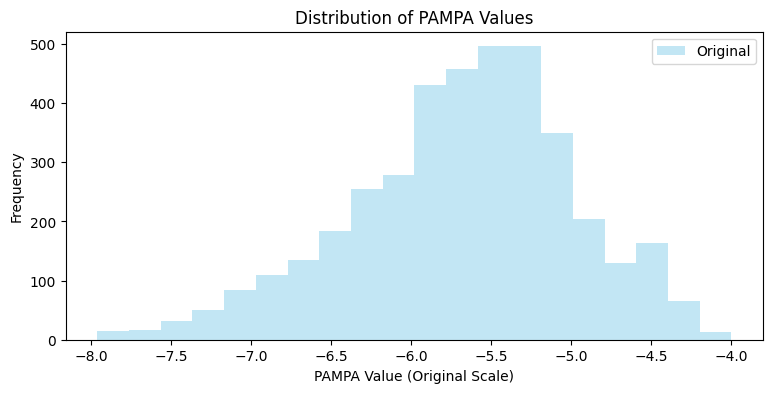


Distribution Statistics (Original Scale):
Original data range: -7.96 to -4.00

Bin Statistics (Original Scale):
Bin 0 (-7.96 to -7.76): 1000 samples
Bin 1 (-7.76 to -7.56): 1000 samples
Bin 2 (-7.56 to -7.37): 1000 samples
Bin 3 (-7.37 to -7.17): 1000 samples
Bin 4 (-7.17 to -6.97): 1000 samples
Bin 5 (-6.97 to -6.77): 1000 samples
Bin 6 (-6.77 to -6.57): 1000 samples
Bin 7 (-6.57 to -6.38): 1000 samples
Bin 8 (-6.38 to -6.18): 1000 samples
Bin 9 (-6.18 to -5.98): 1000 samples
Bin 10 (-5.98 to -5.78): 1000 samples
Bin 11 (-5.78 to -5.58): 1000 samples
Bin 12 (-5.58 to -5.39): 1000 samples
Bin 13 (-5.39 to -5.19): 1000 samples
Bin 14 (-5.19 to -4.99): 1000 samples
Bin 15 (-4.99 to -4.79): 1000 samples
Bin 16 (-4.79 to -4.59): 1000 samples
Bin 17 (-4.59 to -4.40): 1000 samples
Bin 18 (-4.40 to -4.20): 1000 samples
Bin 19 (-4.20 to -4.00): 1009 samples


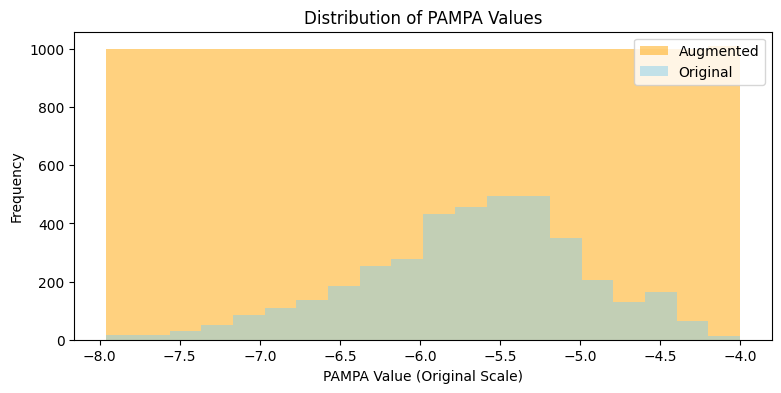


Distribution Statistics (Original Scale):
Original data range: -7.96 to -4.00
Augmented data range: -7.96 to -4.00
Total samples - Original: 3963, Augmented: 20009

Dataset splits:
Train set size: 23972
Validation set size: 1321
Test set size: 1322

Model initialized on device: cuda

Model Configuration:
node_features: 37
edge_features: 17
kwargs: {'num_heads': 8, 'num_layers': 6, 'dropout': 0.4, 'attention_type': 'multihead', 'message_passing': 'gat', 'pooling_strategy': 'attention', 'use_edge_features': True}
hidden_channels: 256
__class__: <class '__main__.ModularGraphAttentionTransformer'>
num_heads: 8
num_layers: 6
dropout: 0.4
attention_type: multihead
message_passing: gat
pooling_strategy: attention
use_edge_features: True

Total Parameters: 1,009,154
Trainable Parameters: 1,009,154
Model Size: 3.85 MB


Training:   0%|          | 0/100 [00:00<?, ?it/s]


Early stopping triggered

Error saving model: 'ModelTrainer' object has no attribute 'scaler'


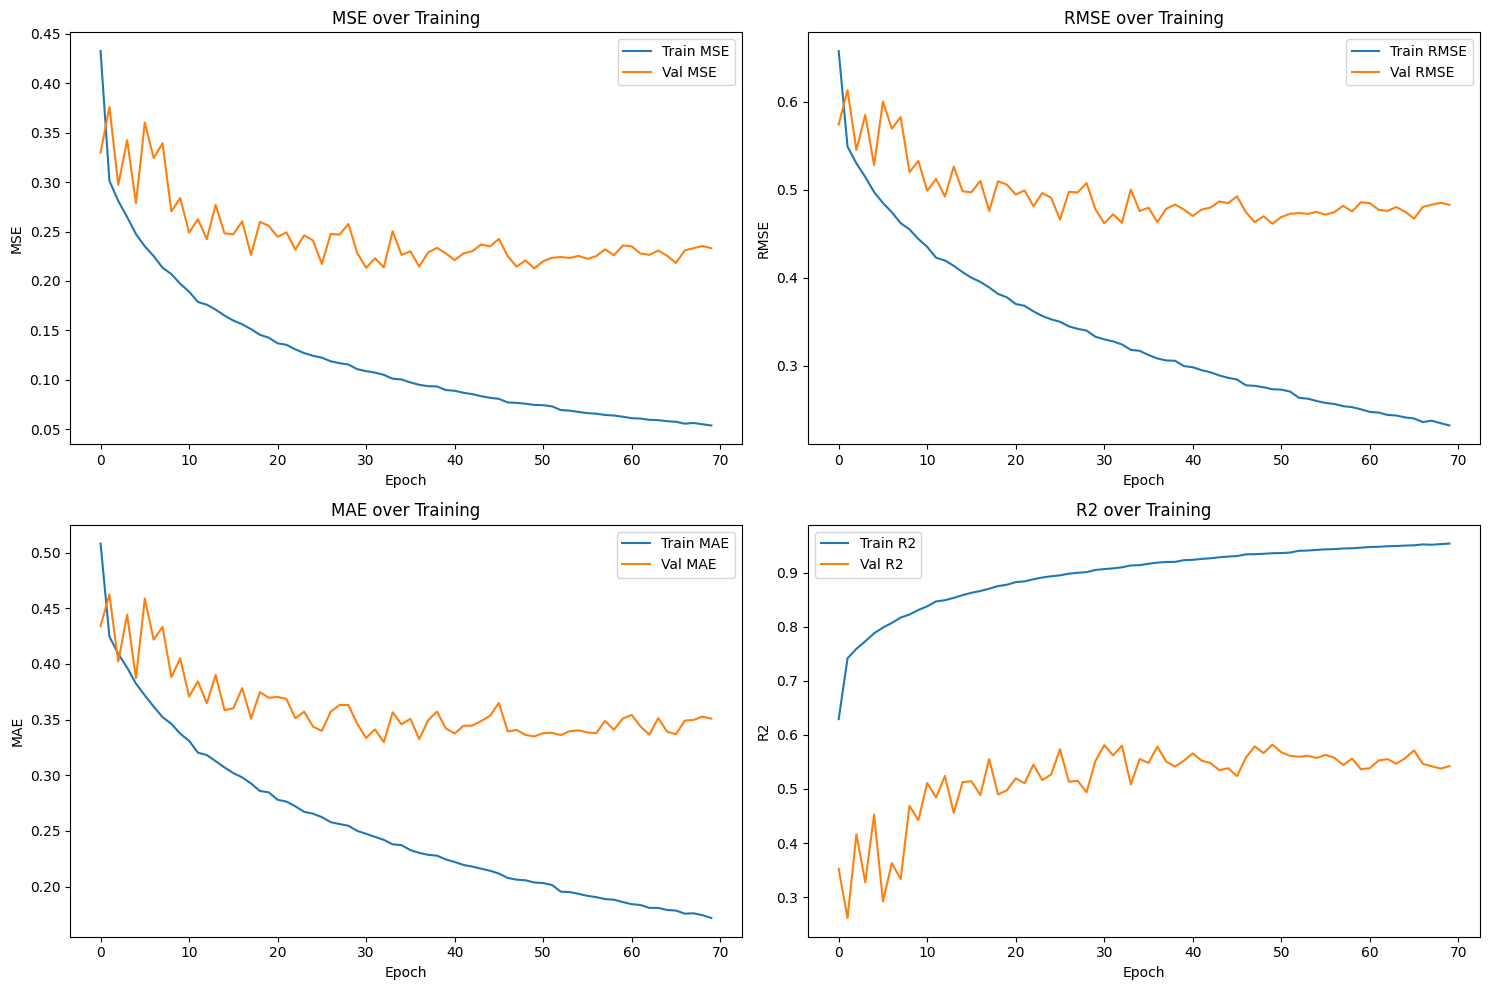

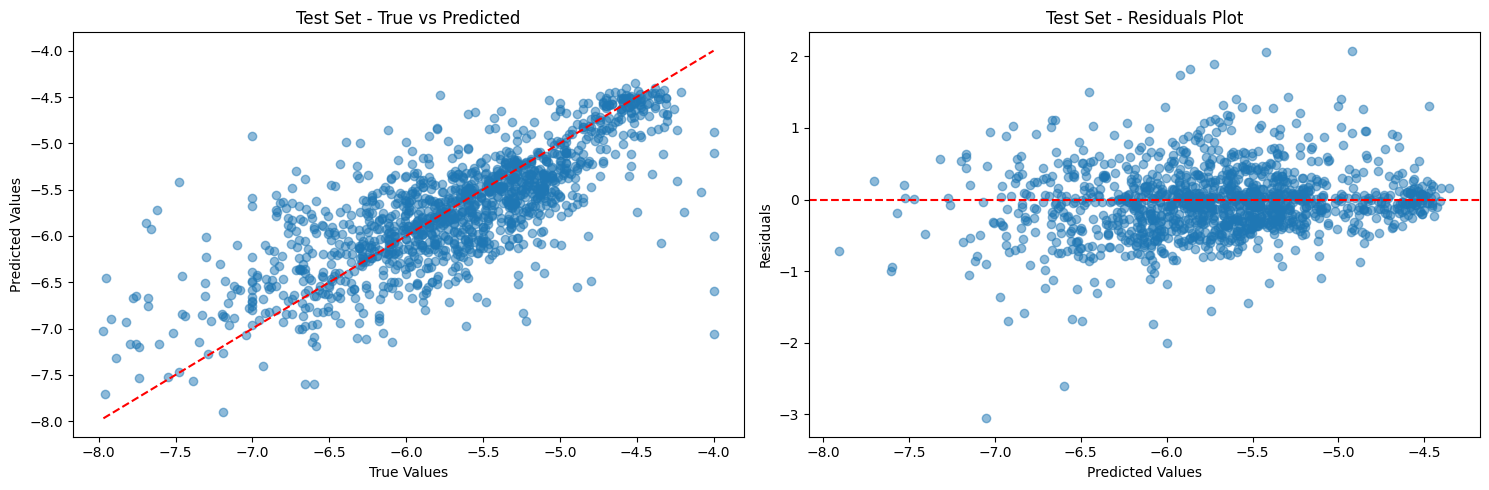


Test Set Results:
MSE: 0.2275
RMSE: 0.4770
MAE: 0.3444
R2: 0.5629


<ipython-input-12-265ba59d5127>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [ ]:
# @title Train Model

config = {
    'batch_size': 16,
    'hidden_channels': 256,
    'num_heads': 8,
    'num_layers': 6,
    'dropout': 0.2,
    'learning_rate': 0.001,
    'weight_decay': 1e-6,
    'num_epochs': 100,
    'min_lr': 1e-7,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'scaler': dataset
}

node_features = 37
edge_features = 17

model, results, test_metrics = main_training_loop(
    dataset=dataset,
    node_features=node_features,
    edge_features=edge_features,
    config=config
)

# 4. Make predictions with trained model
def predict(model, data, device):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        prediction = model(data)
    return prediction.cpu().numpy()

# Example prediction on a single graph
example_graph = dataset[0]
prediction = predict(model, example_graph, device='cuda' if torch.cuda.is_available() else 'cpu')

# 5. Save and load model
# Save
def save_model(model, path='model_checkpoint.pt'):
    """Save model with its configuration."""
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': {
            'node_features': model.config['node_features'],
            'edge_features': model.config['edge_features'],
            'hidden_channels': model.config['hidden_channels'],
            'num_heads': model.config['num_heads'],
            'num_layers': model.config['num_layers'],
            'dropout': model.config['dropout']
        }
    }, path)

def load_model(checkpoint_path):
    """Load model from checkpoint."""
    checkpoint = torch.load(checkpoint_path)
    config = checkpoint['config']

    model.load_state_dict(checkpoint['model_state_dict'])
    return model

save_model(model, 'model_checkpoint.pt')

loaded_model = load_model('model_checkpoint.pt')
